<a href="https://www.kaggle.com/code/anjalisjain/model-updated?scriptVersionId=95284438" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
## Problem

#### * Pneumonia can range from a mild to serious or life-threatening infection and can sometimes lead to death.
#### * Detected using X-ray imaging.
#### * Commonly misclassified as other diseases since radiographs are not particularly clear.

## Proposed Solution

#### * Machine learning models can be used to identify pneumonia in chest X-rays
#### * Intend to develop robust classifiers using Support Vector Machine (SVM) machine learning technique  to detect the presence of Pneumonia in chest X-ray images



In [3]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats

## Dataset

#### * 5856 labelled chest X-rays
#### * 4273 X-ray images are from different subjects affected by pneumonia
#### *1583 X-ray images are labelled as not having pneumonia.
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


## Dataset and Preprocessing

#### * High quality JPEG images with resolution of at least 1280 x 720 pixels
#### * Image -> Grayscale -> Resize 
#### * ‘1’ - pneumonia (positive) samples
#### * ‘0’- pneumonia (negative) samples


In [4]:

def load_data(path, mode="train"):

    images = []
    labels = []
    img_size=256
    normal_limit=500
    p_limit=500    
    
    folder_names = []
    for entry_name in os.listdir(path):
        entry_path = os.path.join(path, entry_name)
        if os.path.isdir(entry_path):
            folder_names.append(entry_name)
        
    print('The Categories are',folder_names)
    
    if mode == "train":
        for folder in folder_names:
            if folder == "PNEUMONIA":
                limit= p_limit
            else:
                limit= normal_limit
            for idx, filename in enumerate(os.listdir(os.path.join(path,folder))):
                img_path = os.path.join(path,folder)
                img = cv2.imread(os.path.join(img_path,filename)) 
                if img is not None:
                    img  = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)   
                    img = cv2.resize(img,(img_size, img_size))
                    images.append(img)
                    if folder == 'NORMAL':
                        labels.append(0)
                        #print('normal')
                    else:
                        labels.append(1)
                        #print('PNE')
                if idx >= limit-1:
                    break
    else:
        for folder in folder_names:
            for idx, filename in enumerate(os.listdir(os.path.join(path,folder))):
                img_path = os.path.join(path,folder)
                img = cv2.imread(os.path.join(img_path,filename)) 
                if img is not None:
                    img  = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)   
                    img = cv2.resize(img,(img_size, img_size))
                    images.append(img)
                    if folder == 'NORMAL':
                        labels.append(0)
                        #print('normal')
                    else:
                        labels.append(1)
                        #print('PNE')
            
    images,labels=np.array(images),np.array(labels)
    print(images.shape)
    return images, labels
#print(labels)

In [5]:
# Load data
train_path = "../input/chest-xray-pneumonia/chest_xray/train/"
test_path = "../input/chest-xray-pneumonia/chest_xray/test/"

x_train_images,y_train = load_data(train_path,mode="train")
x_test_images, y_test = load_data(test_path)

The Categories are ['PNEUMONIA', 'NORMAL']
(1000, 256, 256)
The Categories are ['PNEUMONIA', 'NORMAL']
(624, 256, 256)


## Feature Extraction

#### * Extract 10 features from all the images to form a feature vector for each sample: variance, mean, standard deviation, skew, kurtosis, entropy, canny edges, local binary pattern (LBP), Sobel X, and Sobel Y. [in progress]
#### * LBP : Local Binary Pattern (LBP) is a simple yet very efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number
#### * Canny Edges : makes it easy to segment the image (break it up into separate objects or areas), which can then be recognised separately.
#### * Entropy : defined as corresponding states of intensity level which individual pixels can adapt. It is used in the quantitative analysis and evaluation image details, the entropy value is used as it provides better comparison of the image details


(624, 196614)


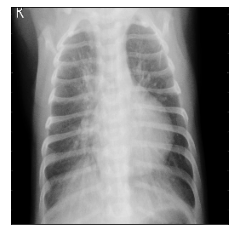

1


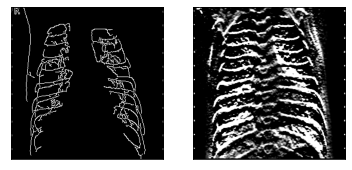

In [6]:
from skimage.feature import multiblock_lbp
normal_limit=500
p_limit=500  
img_size=256

def get_feature_vector(images):
    kernel = np.ones((3,3),np.uint8)
    #print(kernel)
    var_vector = np.empty((len(images),1))
    lbp_vector = np.empty((len(images),1))
    mean_vector = np.empty((len(images),1))
    std_vector = np.empty((len(images),1))
    skew_vector = np.empty((len(images),1))
    kurto_vector = np.empty((len(images),1))
    entropy_vector = np.empty((len(images),1))
    canny_vector = np.empty((len(images),img_size*img_size))
    sobelX_vector = np.empty((len(images),img_size*img_size))
    sobelY_vector = np.empty((len(images),img_size*img_size))

    for idx, image in enumerate(images):
        x, bins = np.histogram(image,bins=255, density=False)
        var_vector[idx] = np.var(x)
        
        lbp = multiblock_lbp(image, 0,0,28,28)
        lbp_vector[idx] = lbp
        
        mean_vector[idx] = np.mean(x)
        std_vector[idx] = np.std(x)
        skew_vector[idx] = stats.skew(x)
        kurto_vector[idx] = stats.kurtosis(x)
        entropy_vector[idx] = stats.entropy(x)
        
        canny = cv2.Canny(image,40,200)
        canny_vector[idx] = np.array(canny.flatten())
    
        sobelX = cv2.Sobel(image,cv2.CV_8UC1,1,0,ksize=3)
        sobelX_vector[idx] = np.array(sobelX.flatten())
        sobelY = cv2.Sobel(image,cv2.CV_8UC1,0,1,ksize=3)
        sobelY_vector[idx] = np.array(sobelY.flatten())
    feature_vector = np.empty((len(images),0))
    #feature_vector=np.append(feature_vector,mean_vector,axis=1)
    feature_vector=np.append(feature_vector,lbp_vector,axis=1)
    feature_vector=np.append(feature_vector,var_vector,axis=1)
    feature_vector=np.append(feature_vector,std_vector,axis=1)
    feature_vector=np.append(feature_vector,skew_vector,axis=1)
    feature_vector=np.append(feature_vector,kurto_vector,axis=1)
    feature_vector=np.append(feature_vector,entropy_vector,axis=1)
    feature_vector=np.append(feature_vector,canny_vector,axis=1)
    feature_vector=np.append(feature_vector,sobelX_vector,axis=1)
    feature_vector=np.append(feature_vector,sobelY_vector,axis=1)
    
    return feature_vector



#feature_vector=np.append(feature_vector,,axis=1)

# Generate features
x_train = get_feature_vector(x_train_images)

x_test = get_feature_vector(x_test_images)


print(x_test.shape)
from random import randrange
limit = 500
i = randrange(limit*2)

plt.imshow(x_train_images[i],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()
print(y_train[i])

#Canny
canny = cv2.Canny(x_train_images[i],40,200)


#Sobel
sobelY = cv2.Sobel(x_train_images[i],cv2.CV_8UC1,0,1,ksize=5)

preview = [canny,sobelY]
i=0
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(preview[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

del x_train_images
del x_test_images

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
# print(xtest)

# Shuffle train data
from sklearn.utils import shuffle

x_train, y_train = shuffle(x_train,y_train)
# x_train, y_train = x_train[:1000], y_train[:1000]

[0.97  0.95  0.965 0.945 0.955]
Cross validation Accuracy: 0.96 (+/- 0.02)
Train Accuracy: 1.0
Test Accuracy: 0.8557692307692307


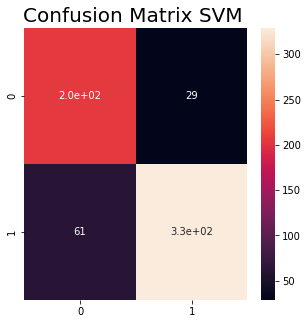

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       234
           1       0.92      0.84      0.88       390

    accuracy                           0.86       624
   macro avg       0.84      0.86      0.85       624
weighted avg       0.86      0.86      0.86       624



In [7]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report

clf = svm.SVC(kernel = "linear", random_state=0)

scores = cross_val_score(clf, x_train, y_train, cv=5)
print(scores)
print("Cross validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

clf.fit(x_train, y_train)
ypredict_test = clf.predict(x_test)
#print(clf.score(xtest,ytest))

ypredict_train = clf.predict(x_train)
print("Train Accuracy:",metrics.accuracy_score(y_train, ypredict_train))

print("Test Accuracy:",metrics.accuracy_score(y_test, ypredict_test))

cm = confusion_matrix(y_test, ypredict_test)
#cm = confusion_matrix(ytrain, ypredict)

plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix SVM ', fontsize = 20)
plt.show()

print(classification_report(y_test,ypredict_test))
#print(classification_report(ytrain,ypredict))

In [8]:
# Save model
import pickle
filename = 'finalized_model_svm.sav'
pickle.dump(clf, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)



0.8557692307692307


In [9]:
#Random Forest

[0.895 0.875 0.85  0.855 0.905]
Cross validation Accuracy Random Forest: 0.88 (+/- 0.04)
Train Accuracy: 1.0
0.7483974358974359
Test Accuracy: 0.7483974358974359


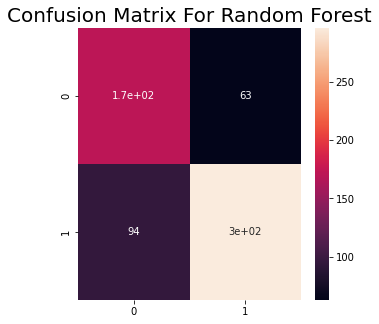

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       234
           1       0.82      0.76      0.79       390

    accuracy                           0.75       624
   macro avg       0.73      0.74      0.74       624
weighted avg       0.76      0.75      0.75       624



In [10]:
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report

rfc = RandomForestClassifier(n_estimators=100)

scores = cross_val_score(rfc, x_train, y_train, cv=5)
print(scores)
print("Cross validation Accuracy Random Forest: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

rfc.fit(x_train, y_train)


ypredict_train = rfc.predict(x_train)
print("Train Accuracy:",metrics.accuracy_score(y_train, ypredict_train))

ypredict_test = rfc.predict(x_test)
print(rfc.score(x_test,y_test))
print("Test Accuracy:",metrics.accuracy_score(y_test, ypredict_test))

cm = confusion_matrix(y_test, ypredict_test)
# #cm = confusion_matrix(ytrain, ypredict)

plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix For Random Forest', fontsize = 20)
plt.show()

print(classification_report(y_test,ypredict_test))

In [11]:
# Save model
import pickle
filename_rfc = 'finalized_model_rfc.sav'
pickle.dump(rfc, open(filename_rfc, 'wb'))
loaded_model_rfc = pickle.load(open(filename_rfc, 'rb'))
result = loaded_model_rfc.score(x_test, y_test)
print(result)
y_proba = loaded_model_rfc.predict_proba(x_test)
print(y_proba)


0.7483974358974359
[[0.34 0.66]
 [0.59 0.41]
 [0.49 0.51]
 ...
 [0.79 0.21]
 [0.58 0.42]
 [0.53 0.47]]


In [17]:
test1 = "../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg"
test0 = "../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0013-0001.jpeg"

In [18]:
def image_convert2(path,fs):
    images = []
    labels = []
    normal_limit=1
    p_limit=0
    img_size=256

    img = cv2.imread(path) 
    if img is not None:
        img  = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)   
        img = cv2.resize(img,(img_size, img_size))
        images.append(img)
    images,labels=np.array(images),np.array(labels)
    

    feature_vector = get_feature_vector(images)
    
    return feature_vector


fs = np.empty((1,0))
fs2 = image_convert2(test1,fs)

#fs2 = sc.fit_transform(fs2)
print(fs2)
y_prob_svm = clf.predict(fs2)
print(y_prob_svm, "SVM")
y_prob_rfc = rfc.predict(fs2)
print(y_prob_rfc, "RFC")

[[  160.         48932.13723952   221.20609675 ...     0.
      0.             0.        ]]
[0] SVM
[0] RFC
